# Importing Important Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers


In [2]:
Batch_Size = 32 # 32 images in 1 batch
Channels = 3  # RGB
Image_Size = 256  # 256x256
Epoches = 50  # for training purpose


# Load Training and Validation data

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    batch_size=Batch_Size,
    shuffle=True,
    image_size=(Image_Size, Image_Size)
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "valid",
    batch_size=Batch_Size,
    shuffle=True,
    image_size=(Image_Size, Image_Size)
)


Found 3208 files belonging to 20 classes.
Found 100 files belonging to 20 classes.


# Load Class Names

In [4]:
class_names = train_ds.class_names
for class_name in class_names:
    print(class_name)


ABBOTTS BABBLER
ABBOTTS BOOBY
ABYSSINIAN GROUND HORNBILL
AFRICAN CROWNED CRANE
AFRICAN EMERALD CUCKOO
AFRICAN FIREFINCH
AFRICAN OYSTER CATCHER
AFRICAN PIED HORNBILL
AFRICAN PYGMY GOOSE
ALBATROSS
ALBERTS TOWHEE
ALEXANDRINE PARAKEET
ALPINE CHOUGH
ALTAMIRA YELLOWTHROAT
AMERICAN AVOCET
AMERICAN BITTERN
AMERICAN COOT
AMERICAN FLAMINGO
AMERICAN GOLDFINCH
AMERICAN KESTREL


# IMAGE VISUALIZATION

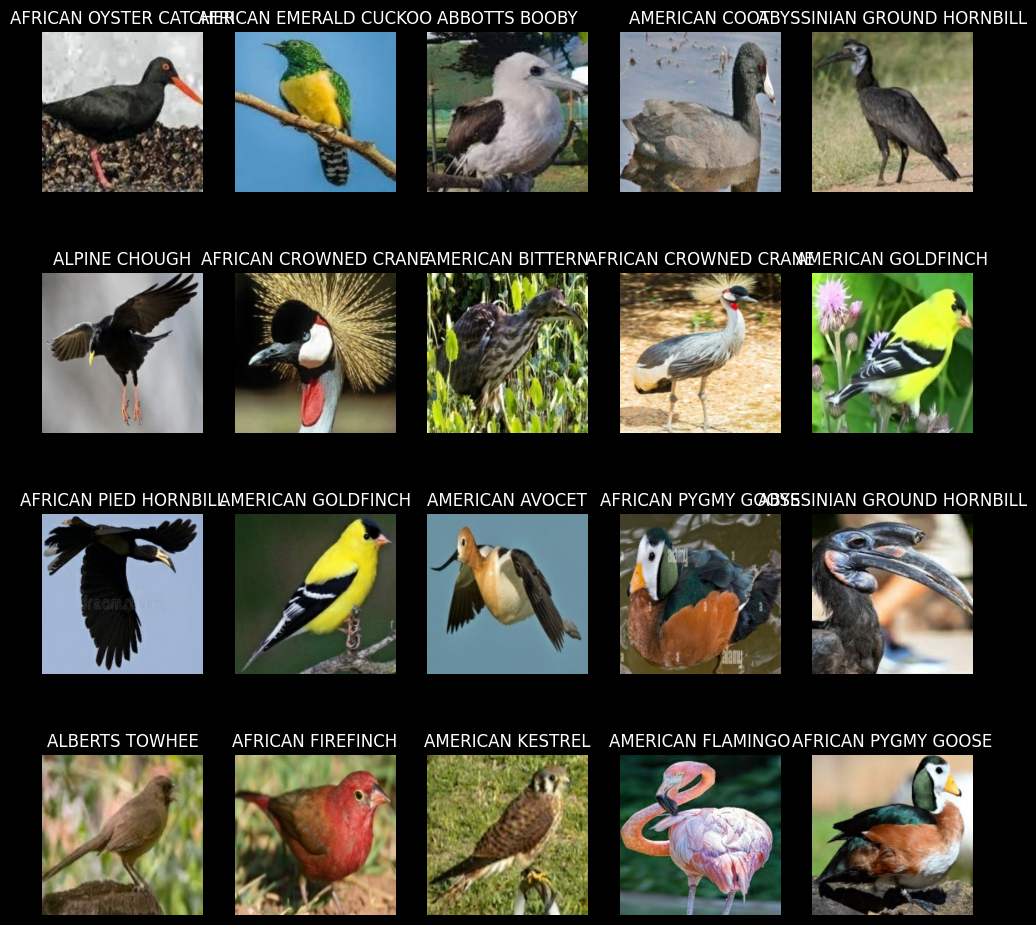

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(20):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")
plt.show()


In [6]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_Size, Image_Size),
    layers.experimental.preprocessing.Rescaling(1./255),
])


# Data Agumentation

In [7]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomContrast(0.2),  # Add random contrast adjustment
  layers.experimental.preprocessing.RandomZoom(0.2),      # Add random zoom
])


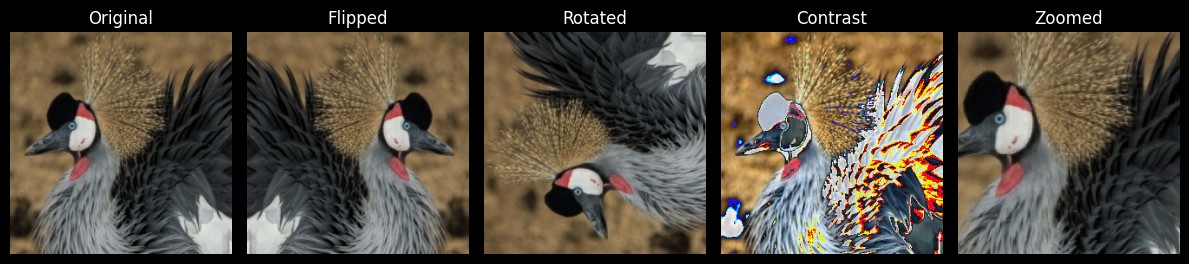

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Select a single image from the dataset
image_index = 1
image = next(iter(train_ds.unbatch().skip(image_index).take(1)))[0]

# Apply different augmentations to the image
flipped_image = tf.image.flip_left_right(image)
rotated_image = tf.image.rot90(image)
contrast_image = tf.image.adjust_contrast(image, 2)  # Increase contrast
zoomed_image = tf.image.central_crop(image, 0.7)     # Zoom into the image

# Plot the original and augmented images
plt.figure(figsize=(12, 4))
titles = ["Original", "Flipped", "Rotated", "Contrast", "Zoomed"]
images = [image, flipped_image, rotated_image, contrast_image, zoomed_image]

for i in range(len(images)):
    plt.subplot(1, len(images), i + 1)
    plt.title(titles[i], fontsize=12)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

plt.tight_layout()
plt.show()


# VGG-16


In [9]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Define VGG-style CNN architecture
def create_vgg_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    # Block 1
    x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Block 2
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Block 3
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Block 4
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Block 5
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Block 6
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Flatten and dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs, outputs, name='vgg_like')
    return model

# Define input shape and number of classes
input_shape = (Image_Size ,Image_Size, Channels)  # Update the input shape here
num_classes = len(class_names)

# Create VGG-like model
vgg_like_model = create_vgg_model(input_shape, num_classes)

# Compile the model
vgg_like_model.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

# Print model summary
vgg_like_model.summary()

Model: "vgg_like"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        369

In [10]:
vgg_like_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [11]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',   
    patience=5,           
    restore_best_weights=True  
)

# Fit the model with early stopping
history = vgg_like_model.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs=Epoches,
    callbacks=[early_stopping]  # Pass the EarlyStopping callback to the fit method
)


Epoch 1/50
101/101 [==============================] - 121s 1s/step - loss: 3.6046 - accuracy: 0.0823 - val_loss: 2.7206 - val_accuracy: 0.1400
Epoch 2/50
101/101 [==============================] - 173s 2s/step - loss: 2.5965 - accuracy: 0.2032 - val_loss: 2.1570 - val_accuracy: 0.3600
Epoch 3/50
101/101 [==============================] - 245s 2s/step - loss: 2.0186 - accuracy: 0.3837 - val_loss: 1.6537 - val_accuracy: 0.5200
Epoch 4/50
101/101 [==============================] - 235s 2s/step - loss: 1.4095 - accuracy: 0.5636 - val_loss: 1.2028 - val_accuracy: 0.6800
Epoch 5/50
101/101 [==============================] - 268s 3s/step - loss: 1.1437 - accuracy: 0.6421 - val_loss: 1.0033 - val_accuracy: 0.7200
Epoch 6/50
101/101 [==============================] - 262s 3s/step - loss: 0.9288 - accuracy: 0.7042 - val_loss: 1.0000 - val_accuracy: 0.7200
Epoch 7/50
101/101 [==============================] - 260s 3s/step - loss: 0.7466 - accuracy: 0.7603 - val_loss: 0.8399 - val_accuracy: 0.7400

# Saving the Model

In [14]:
import pickle

In [16]:
with open('model_VGG16' , 'wb') as VGG16:
    pickle.dump(history , VGG16)

In [17]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "test",
    batch_size=Batch_Size,
    shuffle=True,
    image_size=(Image_Size, Image_Size)
)

Found 100 files belonging to 20 classes.


# Confusion Matrix and other important parameters


4/4 [==============================] - 1s 180ms/step - loss: 1.0037 - accuracy: 0.7500
Test Loss: 1.0037344694137573
Test Accuracy: 0.75
4/4 [==============================] - 1s 169ms/step
F1 Score: 0.02678321678321678
Recall: 0.03
Precision: 0.024583333333333332


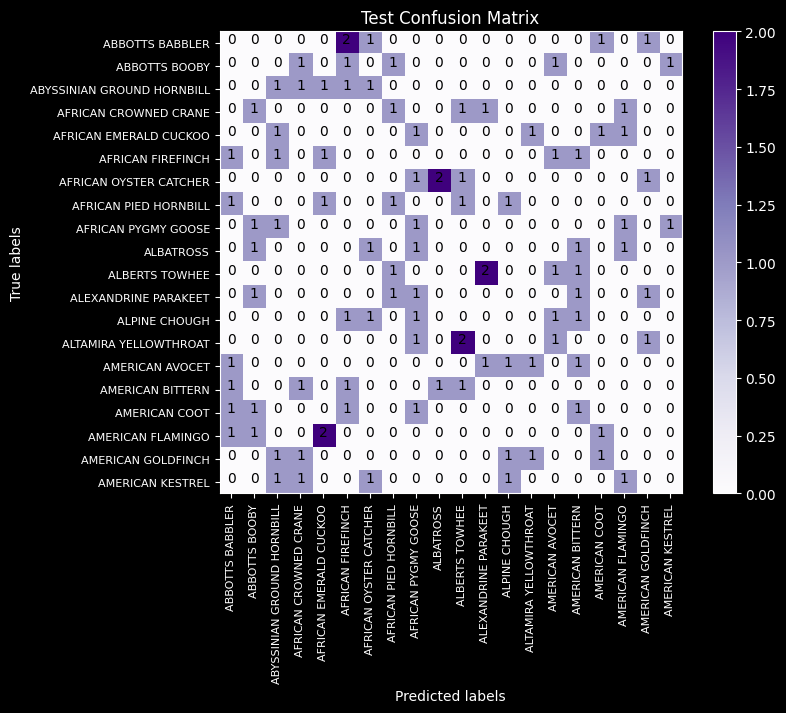

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
import tensorflow as tf

# Evaluate the model on the test dataset
test_loss, test_accuracy = vgg_like_model.evaluate(test_ds)

print("Test Loss:", test_loss)  # Print test loss here
print("Test Accuracy:", test_accuracy)

# Predict labels for the test dataset
predictions = vgg_like_model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels for the test dataset
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Compute additional metrics
f1 = f1_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
precision = precision_score(true_labels, predicted_labels, average='weighted')

print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix , cmap=plt.cm.Purples)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks(np.arange(len(class_names)), class_names, rotation=90 , fontsize=8)
plt.yticks(np.arange(len(class_names)), class_names , fontsize=8)
plt.colorbar()

for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment="center", fontsize = 10 , color="black")

plt.title("Test Confusion Matrix")
plt.show()


4/4 [==============================] - 1s 178ms/step - loss: 1.0037 - accuracy: 0.7500
Test Loss: 1.0037344694137573
Test Accuracy: 0.75
4/4 [==============================] - 1s 171ms/step
Classification Report:
                            precision    recall  f1-score   support

           ABBOTTS BABBLER       0.00      0.00      0.00         5
             ABBOTTS BOOBY       0.00      0.00      0.00         5
ABYSSINIAN GROUND HORNBILL       0.17      0.20      0.18         5
     AFRICAN CROWNED CRANE       0.00      0.00      0.00         5
    AFRICAN EMERALD CUCKOO       0.20      0.20      0.20         5
         AFRICAN FIREFINCH       0.29      0.40      0.33         5
    AFRICAN OYSTER CATCHER       0.00      0.00      0.00         5
     AFRICAN PIED HORNBILL       0.20      0.20      0.20         5
       AFRICAN PYGMY GOOSE       0.00      0.00      0.00         5
                 ALBATROSS       0.33      0.20      0.25         5
            ALBERTS TOWHEE       0.17 

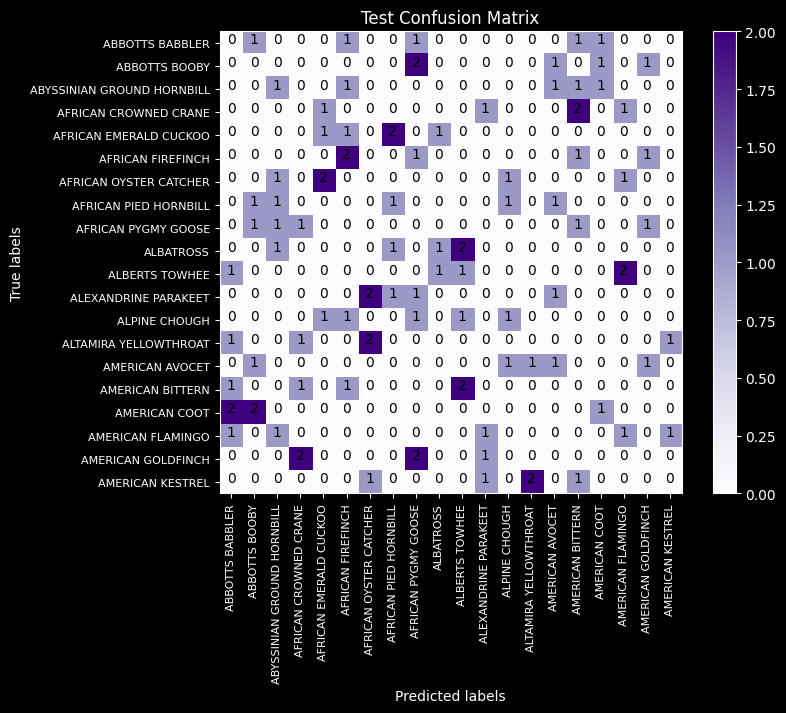

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

# Evaluate the model on the test dataset
test_loss, test_accuracy = vgg_like_model.evaluate(test_ds)

print("Test Loss:", test_loss)  # Print test loss here
print("Test Accuracy:", test_accuracy)

# Predict labels for the test dataset
predictions = vgg_like_model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels for the test dataset
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Generate classification report

print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix , cmap=plt.cm.Purples)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks(np.arange(len(class_names)), class_names, rotation=90 , fontsize=8)
plt.yticks(np.arange(len(class_names)), class_names , fontsize=8)
plt.colorbar()

for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment="center", fontsize=10 , color="black")

plt.title("Test Confusion Matrix")
plt.show()


# Ploting Model Accuracy and loss curves


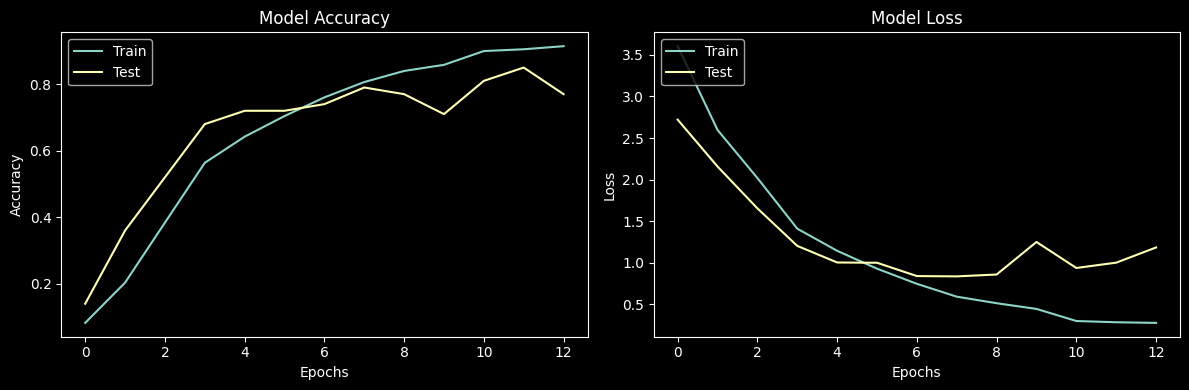

In [22]:
import matplotlib.pyplot as plt

# Plotting model accuracy and loss for both training and test data
plt.figure(figsize=(12, 4))

# Plotting model accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])  # Adding validation accuracy
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')

# Plotting model loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])  # Adding validation loss
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()


# Testing The Model

first image to predict
actual label: AFRICAN PIED HORNBILL
1/1 [==============================] - 0s 318ms/step
predicted label: AFRICAN PIED HORNBILL


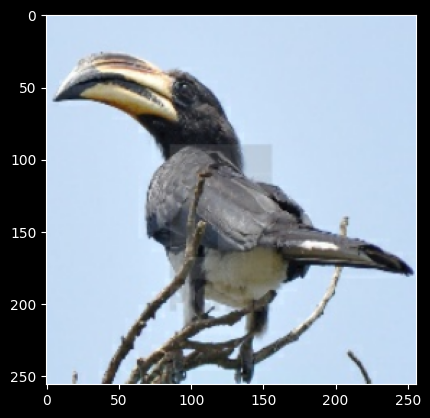

In [24]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = vgg_like_model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [25]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 33ms/step


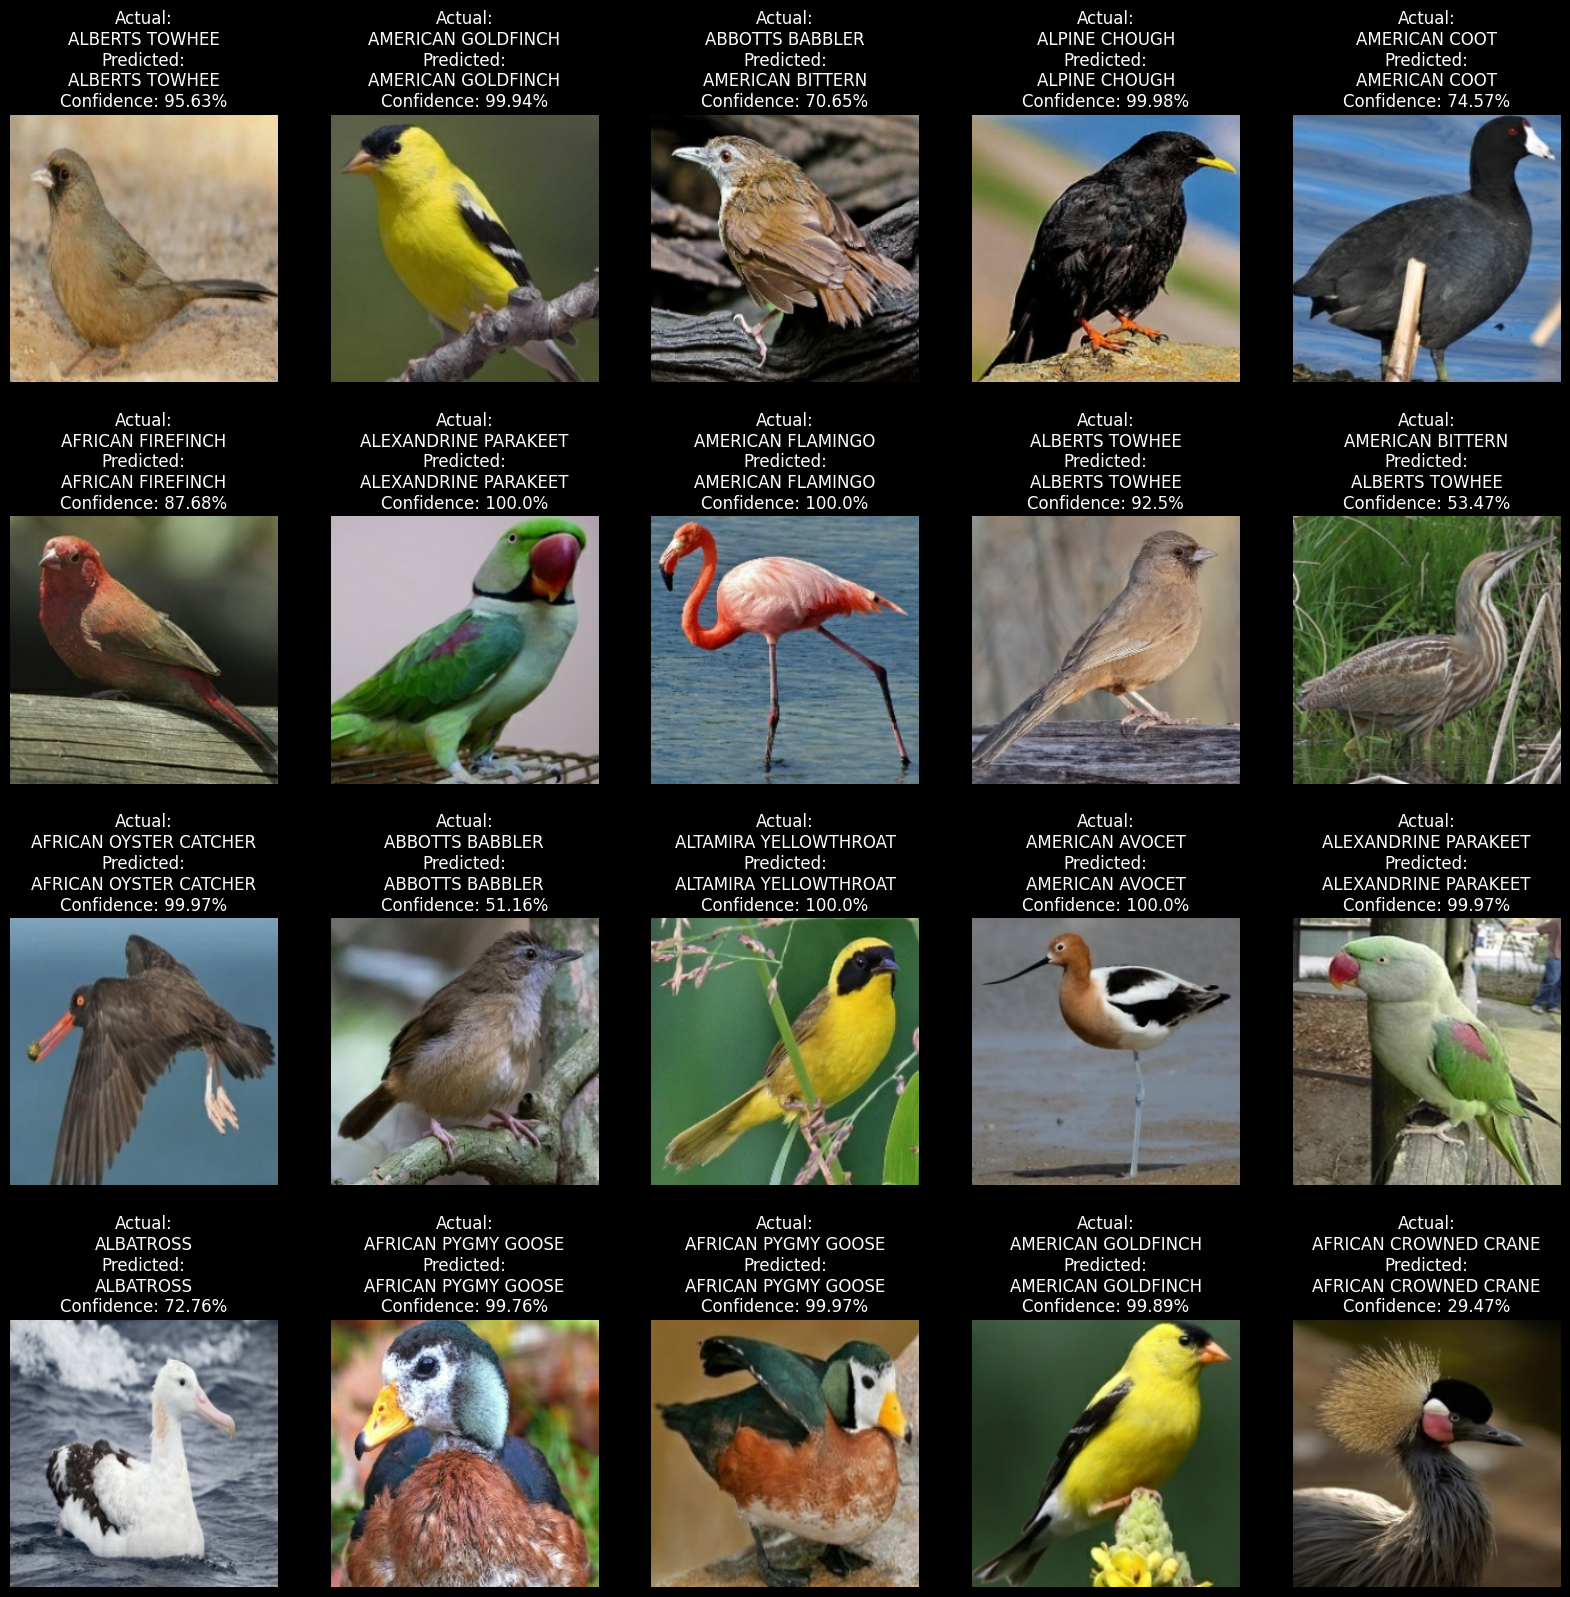

In [26]:
plt.figure(figsize=(20, 20))  # Adjusted figsize for a 4x5 grid
for images, labels in test_ds.take(1):
    for i in range(20):  # 4x5 grid, so 20 images
        ax = plt.subplot(4, 5, i + 1)  # 4 rows, 5 columns
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(vgg_like_model, images[i].numpy())  # Assuming you have a predict function
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual:\n{actual_class}\nPredicted:\n{predicted_class}\nConfidence: {confidence}%")  # Displaying actual and predicted classes on separate lines
        
        plt.axis("off")
